# Mask or No Mask? / 마스크 착용 분류 모델
### by Yehoon (Luke) Joo / 주예훈
코로나가 더 심해지고 있는 요즘 시민들의 마스크 착용 여부를 확인하는 일이 필수가 되었습니다. Kaggle에 기재된 마스크 공개 데이터셋과 전이학습을 활용하여 마스크 착용 여부를 분별해주는 딥 러닝 모델을 개발한 노트북을 작성하였습니다.
# Read Datasets

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00038.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_01005.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00045.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00005.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00055.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00053.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00008.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00995.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_01019.jpg
/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_

# Import Modules

In [2]:
import cv2
import inspect
from keras import Sequential, applications
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import matplotlib.pyplot as plt
import random
from timeit import default_timer as timer
from tqdm import tqdm

# Data Preparation
## Train-Validation-Test Split
* Kaggle에 공개된 데이터셋 3가지를 합쳐서 이 모델의 데이터셋을 준비합니다. 
* Train-validation-test split을 위해서 모든 데이터 경로들을 합친 다음에 *80:10:10*의 비율로 분할합니다.
* 또한 고른 분할을 위해 전체 데이터셋을 섞어놓습니다.

In [3]:
# 마스크 착용된 사진들의 디렉토리 모음
with_mask_dirs = ['../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask', 
                  '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithMask',
                  '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask',
                  '../input/covid-face-mask-detection-dataset/New Masks Dataset/Train/Mask',
                  '../input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Mask',
                  '../input/covid-face-mask-detection-dataset/New Masks Dataset/Test/Mask']
# 마스크 미착용된 사진들의 디렉토리 모음
without_mask_dirs = ['../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask',
                     '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask',
                     '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask',
                     '../input/covid-face-mask-detection-dataset/New Masks Dataset/Train/Non Mask',
                     '../input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask',
                     '../input/covid-face-mask-detection-dataset/New Masks Dataset/Test/Non Mask']

# 사진들의 디렉토리와 타겟 값을 dataframe으로 묶음
def folder_to_df(dirs, labels):
    file_list = []
    num_folders = len(dirs)
    for count, folder in enumerate(dirs, start=1):
        for file in sorted(os.listdir(folder)):
            if count < num_folders / 2:
                file_list.append((folder + '/' + file, labels[0]))
            else:
                file_list.append((folder + '/' + file, labels[1]))
    return pd.DataFrame(file_list, columns=['filename', 'class'])

labels = ['With Mask', 'Without Mask'] # 타겟 값: 마스크 착용, 마스크 미착용
all_mask_df = folder_to_df(with_mask_dirs + without_mask_dirs, labels) # 모든 사진들의 디렉토리를 dataframe으로 합침

shuffled_mask_df = all_mask_df.sample(frac=1) # 고른 선택을 위해 데이터 전체의 순서를 섞음

train_df, val_df, test_df = np.split(shuffled_mask_df, 
                                     [int(0.8*len(shuffled_mask_df)), int(0.9*len(shuffled_mask_df))]) # 데이터를 80:10:10의 비율로 train, validation, test 분할

# train, validation, test 세트 확인
print('total dataset : {}\ntraining set  : {}\nvalidation set: {}\ntest set      : {}'.format(all_mask_df.shape, train_df.shape, val_df.shape, test_df.shape))
display(train_df.head(5), val_df.head(5), test_df.head(5))

total dataset : (12798, 2)
training set  : (10238, 2)
validation set: (1280, 2)
test set      : (1280, 2)


,filename,class
5757,../input/face-mask-12k-images-dataset/Face Mas...,With Mask
5910,../input/covid-face-mask-detection-dataset/New...,With Mask
9188,../input/face-mask-12k-images-dataset/Face Mas...,Without Mask
9807,../input/face-mask-12k-images-dataset/Face Mas...,Without Mask
6408,../input/face-mask-12k-images-dataset/Face Mas...,Without Mask


,filename,class
11608,../input/face-mask-12k-images-dataset/Face Mas...,Without Mask
428,../input/face-mask-12k-images-dataset/Face Mas...,With Mask
4641,../input/face-mask-12k-images-dataset/Face Mas...,With Mask
12226,../input/face-mask-12k-images-dataset/Face Mas...,Without Mask
1672,../input/face-mask-12k-images-dataset/Face Mas...,With Mask


,filename,class
8429,../input/face-mask-12k-images-dataset/Face Mas...,Without Mask
3459,../input/face-mask-12k-images-dataset/Face Mas...,With Mask
82,../input/face-mask-12k-images-dataset/Face Mas...,With Mask
6079,../input/covid-face-mask-detection-dataset/New...,With Mask
5288,../input/face-mask-12k-images-dataset/Face Mas...,With Mask


## Data Augmentation
* 훈련 데이터의 과적합을 방지하기 위해 데이터 증강을 적용합니다.
* 이를 위해서 **Image Data Generator**를 사용합니다.
* 예측을 할 때 실제 데이터를 사용하는 것이 중요하기에 훈련 데이터에만 증강을 적용합니다.

In [4]:
train_datagen = ImageDataGenerator(rotation_range=10, # 기울어진 얼굴
                                   zoom_range=0.1, # 확대된 얼굴
                                   horizontal_flip=True, # 좌우 반전된 얼굴
                                   rescale=1.0/255) # 255개의 RGB values에 맞춰서 축소

val_test_datagen = ImageDataGenerator(rescale=1.0/255) # validation

### Generate Image Batches
* Train, validation, test 세트 각각의 image data generator를 데이터 경로에 맞춰서 설정해줍니다.

In [5]:
VAL_BATCH_SIZE = 128
BATCH_SIZE = VAL_BATCH_SIZE * 8

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    target_size=(128,128), # 최대 입력 이미지 크기에 맞춤
    class_mode='binary',
    batch_size=BATCH_SIZE) # 출력 값 2가지: 마스크 착용, 마스크 미착용
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    target_size=(128,128),
    class_mode='binary',
    batch_size=VAL_BATCH_SIZE)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    target_size=(128,128),
    class_mode='binary',
    batch_size=VAL_BATCH_SIZE)

Found 10238 validated image filenames belonging to 2 classes.
Found 1280 validated image filenames belonging to 2 classes.
Found 1280 validated image filenames belonging to 2 classes.


# Examine Images
* 데이터셋에 있는 이미지들을 임의로 확인해봅니다.

In [6]:
def show_img_samples(dirs, num, label):
    folder = random.choice(dirs) # randomly choose folder
    images = random.sample(os.listdir(folder), num) # randomly choose img
    
    plt.figure(figsize=(20, 10))
    for i in range(num):
        plt.subplot(num // 5 + 1, 5, i + 1)
        img = cv2.cvtColor(cv2.imread(folder + '/' + images[i]), cv2.COLOR_BGR2RGB)
        plt.subplots_adjust(hspace=0.001)
        plt.xlabel(label)
        plt.imshow(img)
    plt.show()

## With/Without Masks
* 마스크 착용한/미착용한 이미지들을 확인합니다.

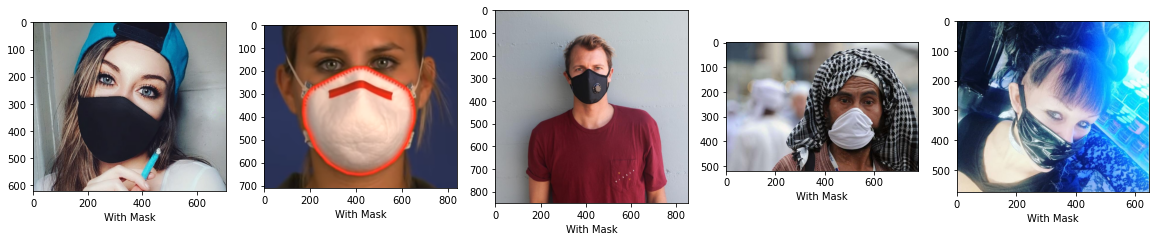

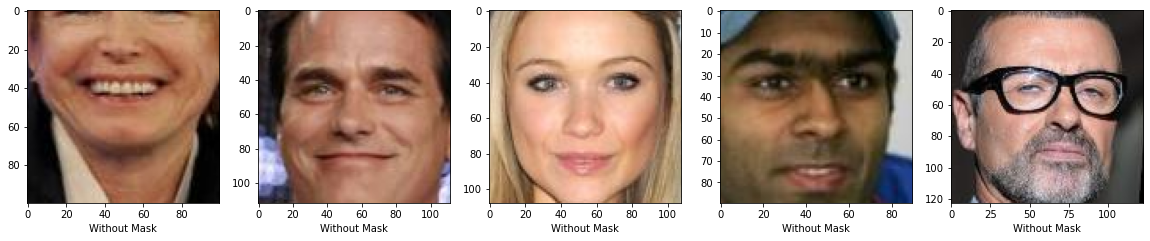

In [30]:
show_img_samples(with_mask_dirs, 5, 'With Mask')
show_img_samples(without_mask_dirs, 5, 'Without Mask')

# Transfer Learning
## Determine Best Pre-trained Base Model
* 이 목적의 전이학습에 적용시키기 가장 적합한 훈련된 모델 선택합니다.
* Keras Applications에 있는 모델들을 짧게 훈련시켜서 각각의 성능 수치들을 (매개변수, 검증 손실, 검증 정확도, 훈련 시간) 비교해서 선택합니다.

### Timing Callback
* 모델의 평균 훈련시간을 기록하기 위한 **Callback**를 만듭니다.

In [9]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

timing_callback = TimingCallback()

## Compare Pretrained Models
* 각 모델들을 비교합니다.
* 출력값이 2가지(마스크 착용, 마스크 미착용)이므로 *loss='binary_crossentropy'*, 그리고 *activation='sigmoid'*으로 설정합니다.
* 여러개의 모델들의 전반적인 성능을 간단히 비교하는 목적이므로 훈련 시간을 단축시키기 위해 *epoch=3*으로 설정합니다.

In [10]:
# Keras Applications에 있는 모델들을 불러옴
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(applications, inspect.isfunction)}
for key in model_dictionary:
    print(key)

# 모델들의 성능 기록
model_benchmarks = {'model_name': [], 'num_model_params': [], 'val_loss': [], 'val_accuracy': [], 'avg_train_time': []}

for model_name, model in tqdm(model_dictionary.items()):
    # NASNet 모델들은 모델에 맞는 input_shape를 사용해야함
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
    elif 'NASNetMobile' in model_name:
        input_shape=(224,224,3)
    # 이외의 모델들은 이미지 최대 크기인 128x128으로 설정
    else:
        input_shape=(128,128,3)

    # 베이스 모델 설정
    pre_trained_model = model(
        include_top=False, 
        pooling='avg', 
        input_shape=input_shape)
    pre_trained_model.trainable = False
    
    # 전이학습 모델 설정
    clf_model = Sequential([
        pre_trained_model,
        Flatten(),
        Dense(1, activation='sigmoid')])
    clf_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    # 모델 훈련
    history = clf_model.fit(
        train_generator,
        epochs=3, # 많은 모델들을 비교해야하므로 epoch를 3으로 설정
        callbacks=[timing_callback],
        validation_data=val_generator)
    
    # 모델 성능 비교를 위한 값들을 기록
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['val_loss'].append(history.history['val_loss'][-1])
    model_benchmarks['val_accuracy'].append(history.history['val_accuracy'][-1])
    model_benchmarks['avg_train_time'].append(sum(timing_callback.logs)/3)

  0%|          | 0/18 [00:00<?, ?it/s]

DenseNet121
DenseNet169
DenseNet201
InceptionResNetV2
InceptionV3
MobileNet
MobileNetV2
NASNetLarge
NASNetMobile
ResNet101
ResNet101V2
ResNet152
ResNet152V2
ResNet50
ResNet50V2
VGG16
VGG19
Xception
29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 107s 10s/step - loss: 0.4670 - accuracy: 0.7810 - val_loss: 0.2190 - val_accuracy: 0.9414
Epoch 2/3
10/10 [==============================] - 66s 7s/step - loss: 0.2017 - accuracy: 0.9456 - val_loss: 0.1232 - val_accuracy: 0.9703
Epoch 3/3
10/10 [==============================] - 66s 7s/step - loss: 0.1249 - accuracy: 0.9652 - val_loss: 0.0900 - val_accuracy: 0.9750


  6%|▌         | 1/18 [04:13<1:11:56, 253.93s/it]

51879936/51877672 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 78s 7s/step - loss: 0.8871 - accuracy: 0.5397 - val_loss: 0.3935 - val_accuracy: 0.8242
Epoch 2/3
10/10 [==============================] - 66s 7s/step - loss: 0.3261 - accuracy: 0.8745 - val_loss: 0.1693 - val_accuracy: 0.9531
Epoch 3/3
10/10 [==============================] - 66s 7s/step - loss: 0.1631 - accuracy: 0.9544 - val_loss: 0.1133 - val_accuracy: 0.9750


 11%|█         | 2/18 [07:56<1:02:44, 235.29s/it]

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 80s 7s/step - loss: 0.6178 - accuracy: 0.6519 - val_loss: 0.2323 - val_accuracy: 0.9492
Epoch 2/3
10/10 [==============================] - 67s 7s/step - loss: 0.2053 - accuracy: 0.9465 - val_loss: 0.1274 - val_accuracy: 0.9688
Epoch 3/3
10/10 [==============================] - 67s 7s/step - loss: 0.1121 - accuracy: 0.9699 - val_loss: 0.0990 - val_accuracy: 0.9734


 17%|█▋        | 3/18 [11:42<57:49, 231.27s/it]  

219062272/219055592 [==============================] - 2s 0us/step
Epoch 1/3
10/10 [==============================] - 82s 7s/step - loss: 0.7202 - accuracy: 0.5809 - val_loss: 0.1729 - val_accuracy: 0.9336
Epoch 2/3
10/10 [==============================] - 67s 7s/step - loss: 0.1587 - accuracy: 0.9441 - val_loss: 0.1229 - val_accuracy: 0.9672
Epoch 3/3
10/10 [==============================] - 66s 7s/step - loss: 0.1137 - accuracy: 0.9732 - val_loss: 0.1158 - val_accuracy: 0.9727


 22%|██▏       | 4/18 [15:31<53:45, 230.39s/it]

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 71s 7s/step - loss: 0.9357 - accuracy: 0.5254 - val_loss: 0.3641 - val_accuracy: 0.8594
Epoch 2/3
10/10 [==============================] - 65s 7s/step - loss: 0.2792 - accuracy: 0.8960 - val_loss: 0.1891 - val_accuracy: 0.9422
Epoch 3/3
10/10 [==============================] - 64s 7s/step - loss: 0.1450 - accuracy: 0.9591 - val_loss: 0.1408 - val_accuracy: 0.9586


 28%|██▊       | 5/18 [19:00<48:14, 222.66s/it]

17227776/17225924 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 67s 6s/step - loss: 0.6610 - accuracy: 0.6346 - val_loss: 0.2795 - val_accuracy: 0.9297
Epoch 2/3
10/10 [==============================] - 64s 6s/step - loss: 0.2172 - accuracy: 0.9457 - val_loss: 0.1430 - val_accuracy: 0.9570
Epoch 3/3
10/10 [==============================] - 64s 6s/step - loss: 0.1191 - accuracy: 0.9692 - val_loss: 0.1050 - val_accuracy: 0.9672


 33%|███▎      | 6/18 [22:22<43:05, 215.47s/it]

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 69s 7s/step - loss: 0.5052 - accuracy: 0.7642 - val_loss: 0.2233 - val_accuracy: 0.9383
Epoch 2/3
10/10 [==============================] - 64s 6s/step - loss: 0.2067 - accuracy: 0.9427 - val_loss: 0.1532 - val_accuracy: 0.9461
Epoch 3/3
10/10 [==============================] - 64s 6s/step - loss: 0.1355 - accuracy: 0.9602 - val_loss: 0.1311 - val_accuracy: 0.9539


 39%|███▉      | 7/18 [25:48<38:57, 212.51s/it]

343613440/343610240 [==============================] - 2s 0us/step
Epoch 1/3
10/10 [==============================] - 98s 8s/step - loss: 0.6738 - accuracy: 0.6056 - val_loss: 0.1606 - val_accuracy: 0.9648
Epoch 2/3
10/10 [==============================] - 75s 7s/step - loss: 0.1258 - accuracy: 0.9695 - val_loss: 0.1127 - val_accuracy: 0.9727
Epoch 3/3
10/10 [==============================] - 74s 7s/step - loss: 0.0883 - accuracy: 0.9783 - val_loss: 0.1087 - val_accuracy: 0.9766


 44%|████▍     | 8/18 [30:12<38:08, 228.90s/it]

19996672/19993432 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 81s 7s/step - loss: 0.9121 - accuracy: 0.5027 - val_loss: 0.4859 - val_accuracy: 0.7953
Epoch 2/3
10/10 [==============================] - 65s 7s/step - loss: 0.4150 - accuracy: 0.8611 - val_loss: 0.2465 - val_accuracy: 0.9531
Epoch 3/3
10/10 [==============================] - 65s 7s/step - loss: 0.2282 - accuracy: 0.9596 - val_loss: 0.1623 - val_accuracy: 0.9695


 50%|█████     | 9/18 [33:57<34:09, 227.73s/it]

171450368/171446536 [==============================] - 3s 0us/step
Epoch 1/3
10/10 [==============================] - 78s 7s/step - loss: 0.6954 - accuracy: 0.5052 - val_loss: 0.6877 - val_accuracy: 0.5258
Epoch 2/3
10/10 [==============================] - 67s 7s/step - loss: 0.6881 - accuracy: 0.5116 - val_loss: 0.6856 - val_accuracy: 0.5938
Epoch 3/3
10/10 [==============================] - 68s 7s/step - loss: 0.6850 - accuracy: 0.6249 - val_loss: 0.6852 - val_accuracy: 0.6000


 56%|█████▌    | 10/18 [37:42<30:14, 226.86s/it]

171319296/171317808 [==============================] - 2s 0us/step
Epoch 1/3
10/10 [==============================] - 77s 7s/step - loss: 0.4967 - accuracy: 0.7899 - val_loss: 0.1796 - val_accuracy: 0.9688
Epoch 2/3
10/10 [==============================] - 67s 7s/step - loss: 0.1263 - accuracy: 0.9724 - val_loss: 0.1227 - val_accuracy: 0.9711
Epoch 3/3
10/10 [==============================] - 67s 7s/step - loss: 0.0840 - accuracy: 0.9774 - val_loss: 0.1148 - val_accuracy: 0.9781


 61%|██████    | 11/18 [41:23<26:15, 225.09s/it]

234700800/234698864 [==============================] - 2s 0us/step
Epoch 1/3
10/10 [==============================] - 80s 7s/step - loss: 0.7120 - accuracy: 0.5021 - val_loss: 0.6945 - val_accuracy: 0.4695
Epoch 2/3
10/10 [==============================] - 69s 7s/step - loss: 0.6956 - accuracy: 0.4674 - val_loss: 0.6960 - val_accuracy: 0.4789
Epoch 3/3
10/10 [==============================] - 69s 7s/step - loss: 0.6934 - accuracy: 0.4993 - val_loss: 0.6896 - val_accuracy: 0.6062


 67%|██████▋   | 12/18 [45:13<22:39, 226.65s/it]

234553344/234545216 [==============================] - 2s 0us/step
Epoch 1/3
10/10 [==============================] - 79s 7s/step - loss: 1.0382 - accuracy: 0.4194 - val_loss: 0.2618 - val_accuracy: 0.9391
Epoch 2/3
10/10 [==============================] - 68s 7s/step - loss: 0.2031 - accuracy: 0.9508 - val_loss: 0.1288 - val_accuracy: 0.9734
Epoch 3/3
10/10 [==============================] - 69s 7s/step - loss: 0.1026 - accuracy: 0.9765 - val_loss: 0.1091 - val_accuracy: 0.9820


 72%|███████▏  | 13/18 [49:04<18:58, 227.74s/it]

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 70s 7s/step - loss: 0.7052 - accuracy: 0.4985 - val_loss: 0.6966 - val_accuracy: 0.4789
Epoch 2/3
10/10 [==============================] - 66s 7s/step - loss: 0.6948 - accuracy: 0.4988 - val_loss: 0.6918 - val_accuracy: 0.4781
Epoch 3/3
10/10 [==============================] - 65s 7s/step - loss: 0.6908 - accuracy: 0.5505 - val_loss: 0.6887 - val_accuracy: 0.5328


 78%|███████▊  | 14/18 [52:32<14:47, 221.94s/it]

94674944/94668760 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 70s 7s/step - loss: 0.8981 - accuracy: 0.5167 - val_loss: 0.2235 - val_accuracy: 0.9438
Epoch 2/3
10/10 [==============================] - 65s 7s/step - loss: 0.1609 - accuracy: 0.9627 - val_loss: 0.1147 - val_accuracy: 0.9711
Epoch 3/3
10/10 [==============================] - 65s 7s/step - loss: 0.0869 - accuracy: 0.9778 - val_loss: 0.1028 - val_accuracy: 0.9734


 83%|████████▎ | 15/18 [56:02<10:54, 218.16s/it]

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 71s 7s/step - loss: 0.8566 - accuracy: 0.4994 - val_loss: 0.7243 - val_accuracy: 0.4758
Epoch 2/3
10/10 [==============================] - 66s 7s/step - loss: 0.7013 - accuracy: 0.5118 - val_loss: 0.6601 - val_accuracy: 0.6094
Epoch 3/3
10/10 [==============================] - 67s 7s/step - loss: 0.6580 - accuracy: 0.6290 - val_loss: 0.6290 - val_accuracy: 0.6602


 89%|████████▉ | 16/18 [59:32<07:11, 215.81s/it]

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 69s 7s/step - loss: 0.7285 - accuracy: 0.5114 - val_loss: 0.6486 - val_accuracy: 0.6742
Epoch 2/3
10/10 [==============================] - 67s 7s/step - loss: 0.6492 - accuracy: 0.6873 - val_loss: 0.6125 - val_accuracy: 0.7656
Epoch 3/3
10/10 [==============================] - 67s 7s/step - loss: 0.6143 - accuracy: 0.7563 - val_loss: 0.5712 - val_accuracy: 0.8258


 94%|█████████▍| 17/18 [1:03:01<03:33, 213.81s/it]

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 71s 7s/step - loss: 0.6190 - accuracy: 0.6530 - val_loss: 0.2556 - val_accuracy: 0.9609
Epoch 2/3
10/10 [==============================] - 66s 7s/step - loss: 0.2122 - accuracy: 0.9685 - val_loss: 0.1313 - val_accuracy: 0.9820
Epoch 3/3
10/10 [==============================] - 66s 7s/step - loss: 0.1246 - accuracy: 0.9787 - val_loss: 0.1021 - val_accuracy: 0.9828


100%|██████████| 18/18 [1:06:33<00:00, 221.83s/it]


## Benchmark Results
* 각 모델의 성능 수치들을 확인하고 비교합니다.

In [12]:
benchmark_df = pd.DataFrame(model_benchmarks)

benchmark_df.to_csv('pretrained_model_benchmarks.csv')

bm_params_df = benchmark_df.sort_values('num_model_params')
bm_params_df.head(10)

,model_name,num_model_params,val_loss,val_accuracy,avg_train_time
6,MobileNetV2,2257984,0.131125,0.953906,489.716313
5,MobileNet,3228864,0.105017,0.967188,423.961969
8,NASNetMobile,4269716,0.162294,0.969531,642.616535
0,DenseNet121,7037504,0.089965,0.975000,79.569398
1,DenseNet169,12642880,0.113288,0.975000,149.552018
15,VGG16,14714688,0.628976,0.660156,1130.113425
2,DenseNet201,18321984,0.098963,0.973437,220.808253
16,VGG19,20024384,0.571156,0.825781,1197.417554
17,Xception,20861480,0.102058,0.982813,1265.309791
4,InceptionV3,21802784,0.140824,0.958594,358.989423


* 모델 크기가 비교적 작으면서 손실값과 정확도가 높고 훈련이 빠른 수치들을 보여준 **DenseNet121**을 베이스 모델로 선택합니다.

# Create Model
* DenseNet121을 기반으로 한 전이학습 모델을 만듭니다. 

In [16]:
pretrained_base = applications.DenseNet121(
    include_top=False, # 128x128의 이미지 크기를 맞추기 위해 False로 설정
    input_shape=(128,128,3), # 이미지 크기와 RGB 값 갯수
    pooling='avg') 
pretrained_base.trainable = False

model = Sequential([
    pretrained_base,
    Flatten(),
    Dense(1, activation='sigmoid')])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

### Early Stopping
* 모델 학습을 검증 손실값이 더 이상 줄어들지 않을 때까지 훈련을 시키기 위해 **EarlyStopping**을 사용합니다.

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0,
    patience=10, # 10번의 epoch 동안 val_loss이 더 이상 줄어들지 않을 때 훈련을 멈춤
    verbose=1,
    mode='min',
    restore_best_weights=True)

# Train Model
* Epoch 횟수를 최대 100번으로 설정하여서 모델을 훈련시킵니다.

In [17]:
EPOCHS = 100

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_generator)

Epoch 1/100
10/10 [==============================] - 73s 7s/step - loss: 0.6689 - accuracy: 0.6697 - val_loss: 0.3297 - val_accuracy: 0.8883
Epoch 2/100
10/10 [==============================] - 65s 7s/step - loss: 0.2829 - accuracy: 0.9121 - val_loss: 0.1604 - val_accuracy: 0.9539
Epoch 3/100
10/10 [==============================] - 66s 7s/step - loss: 0.1654 - accuracy: 0.9559 - val_loss: 0.1160 - val_accuracy: 0.9719
Epoch 4/100
10/10 [==============================] - 65s 7s/step - loss: 0.1141 - accuracy: 0.9699 - val_loss: 0.0986 - val_accuracy: 0.9734
Epoch 5/100
10/10 [==============================] - 66s 7s/step - loss: 0.0978 - accuracy: 0.9761 - val_loss: 0.0867 - val_accuracy: 0.9758
Epoch 6/100
10/10 [==============================] - 65s 7s/step - loss: 0.0913 - accuracy: 0.9750 - val_loss: 0.0813 - val_accuracy: 0.9766
Epoch 7/100
10/10 [==============================] - 65s 7s/step - loss: 0.0819 - accuracy: 0.9788 - val_loss: 0.0780 - val_accuracy: 0.9781
Epoch 8/100
1

* 100번의 epoch 중 검증 손실값이 가장 낮았던 96번째의 모델 weight 값들을 사용합니다.

## Check Model Performance
* 학습된 모델의 손실값과 정확도를 차트로 확인합니다.

Minimum validation loss: 0.03820304572582245
Maximum validation accuracy: 0.991406261920929


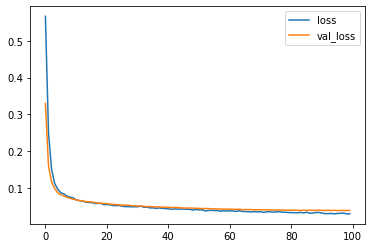

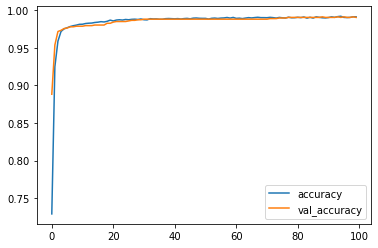

In [18]:
history_df = pd.DataFrame(history.history)
history_df
history_df.loc[:, ['loss', 'val_loss']].plot();
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(history_df['val_accuracy'].max()))

* 이미 많이 학습이 된 베이스 모델(DenseNet121)을 기반으로 하여서 초반부터 손실값과 정확도가 좋게 나온 것으로 보입니다.
* 이후에는 훈련값과 검증값의 차이가 거의 미미했습니다.

## Evaluate Model
* Test 세트로 분할해놓은 데이터로 모델을 평가합니다.

In [19]:
model.evaluate(test_generator)

10/10 [==============================] - 10s 1s/step - loss: 0.0332 - accuracy: 0.9898


[0.03321497142314911, 0.9898437261581421]

* 손실값: 0.0332, 정확도: 0.9898으로 예측률이 좋아보입니다.

## Save Model
* 학습된 모델을 재사용 할 수 있게 저장해놓습니다.

In [20]:
model.save('DenseNet121.h5')

# Model Predictions
* 학습된 모델로 다른 사진들 속 인물들이 마스크를 착용했는지는 예측합니다.

In [21]:
def predict_rand_sample(num, label):
    plt.figure(figsize=(20,10))
    img_dirs = test_df.loc[test_df['class'] == label].sample(num).values[:, 0] # 사진들을 임의로 선택
    for i in range(num):
        plt.subplot(num // 5 + 1, 5, i + 1)
        
        img = cv2.cvtColor(cv2.imread(img_dirs[i]), cv2.COLOR_BGR2RGB)
        processed_img = cv2.resize(img,(128,128))
        processed_img = np.reshape(processed_img,[1,128,128,3])
        processed_img = processed_img/255.0

        prediction = model.predict(processed_img)[0][0] # 사진의 결과값 에측
        if prediction < 0.5:
            plt.xlabel('With Mask')
        else:
            plt.xlabel('Without Mask')
        plt.imshow(img)
    plt.show

### With Mask Predictions
* 마스크 착용/미착용한 사진들의 결과값을 예측합니다.

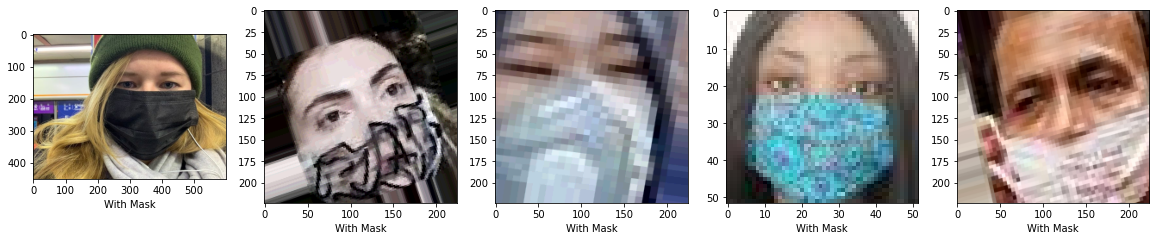

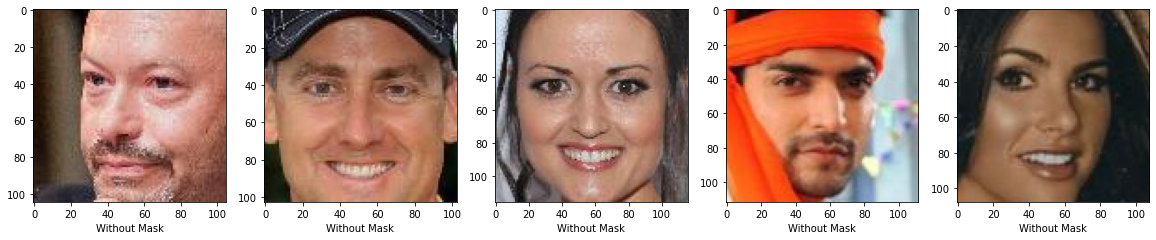

In [29]:
predict_rand_sample(5, 'With Mask')
predict_rand_sample(5, 'Without Mask')

## Private Images Predictions
* 개인 사진들도 학습된 모델로 마스크 착용 여부를 예측해봅니다.

In [25]:
def predict_samples(label):
    folder = '../input/mask-or-no-mask-private-dataset/' + label
    images = os.listdir(folder)
    num = len(images)
    
    plt.figure(figsize=(20,10))
    for i in range(num):
        plt.subplot(num // (num // 2) + 1, 5, i + 1)
        img = cv2.cvtColor(cv2.imread(folder + '/' + images[i]), cv2.COLOR_BGR2RGB)
        plt.xlabel(label)
        plt.imshow(img)
    plt.show()

### With/Without Mask Predictions
* 마스크 착용/미착용한 개인 사진들의 결과값을 예측합니다.

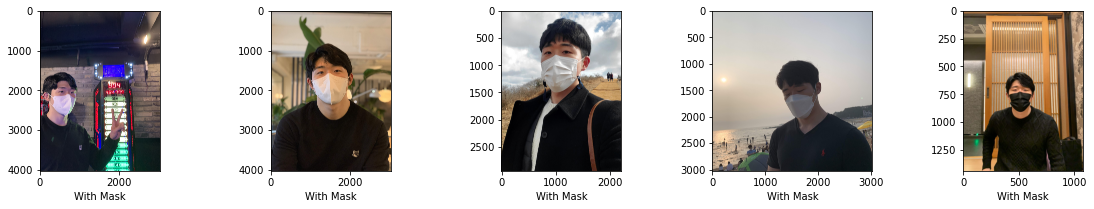

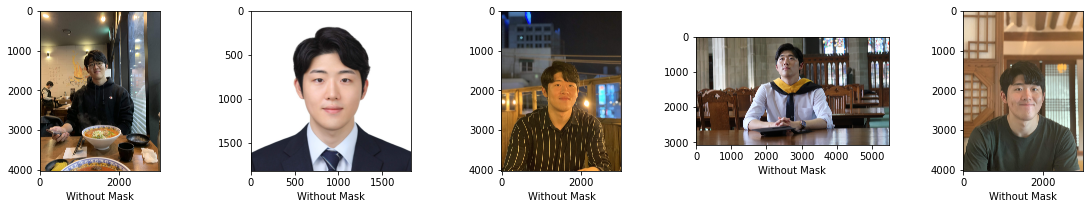

In [28]:
predict_samples('With Mask')
predict_samples('Without Mask')

* 기대한한 결과값들이 잘 나왔습니다.

# Conclusion
전이학습된 딥 러닝 모델로 사진 속 인물의 마스크 착용 여부를 확인하는 것이 가능했습니다. 더 향상된 학습을 위해서는 훈련 데이터와 테스트 데이터 사진들에서 얼굴들만을 잘라내서 적용하면 더 좋은 성능을 이끌어낼 수 있을 것으로 보입니다. 또한 모델을 구축하면서 마스크를 귀에 걸었지만 입을 가리지 않은 사람들을 분류해내는 작업도 가능하면 좋을 것 같다는 생각이 들었습니다.